# Age and Gender Prediction


Part 1 : Training Convolutional Neural Network with Tensorflow and Keras on wiki dataset.







The wiki dataset is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females. 

# imports

In [1]:
# importing library 
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import Input, Model

import tensorflow as tf

# Set Parmeters

In [2]:
n_epochs=30
n_batch_size=34
size= 200
# True to use less number of samples during the traing trials, False to obtain final trained model using all samples.
developing_stage=True 

# Reading and exploring data 

In [6]:
# Here we read data from wiki dataset and explore the data. Exploring is done so that Users 
# look at and understand their data with statistical and visualization methods. 
# This step helps identifying patterns and problems in the dataset, as well as deciding which model or
# algorithm to use in subsequent steps

In [3]:
images = []
ages = []
genders = []
if developing_stage:
    last_idx=5000   
else:
    last_idx=-1

for i in os.listdir(r'C:\Users\Saksham\Desktop\JOVAC\images\wiki_crop')[0:last_idx]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open(r'C:\Users\Saksham\Desktop\JOVAC\images\wiki_crop' + i))

In [4]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df.head(5)

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1


In [5]:
def get_gender(x):
    return "Femal" if x else "Male"

Age and Gender :  53 ,  Femal


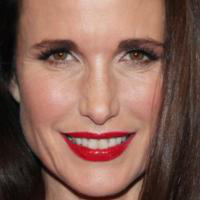

In [37]:
# 0 corresponds to male, 1 corresponds to female.
rand_number = random.randint(0,len(df))
print("Age and Gender : ",df['Ages'][rand_number],", ", get_gender(df['Genders'][rand_number]))
display(df['Images'][rand_number])

In [7]:
df.describe()

,Ages,Genders
count,5000.000000,5000.000000
mean,34.114600,0.478000
std,20.281305,0.499566
min,1.000000,0.000000
25%,24.000000,0.000000
50%,30.000000,0.000000
75%,46.000000,1.000000
max,115.000000,1.000000


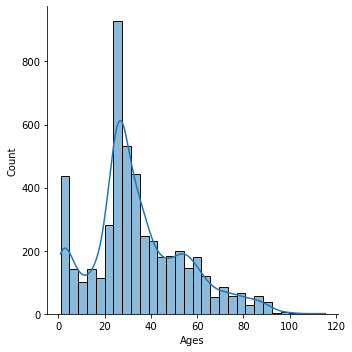

In [8]:
sns.displot(df['Ages'],kde=True, bins=30)

# Data modification 
Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. On the other hand, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. So it is better to just remove over 80s and only have a model that can predict the ages of people over 4 and under 80.

In [9]:
print("Number of Samples before remove: ", df.shape)
df = df[(df['Ages'] > 4) & (df['Ages'] < 70)]
print("Number of Samples after remove: ", df.shape)

Number of Samples before remove:  (5000, 3)
Number of Samples after remove:  (4221, 3)


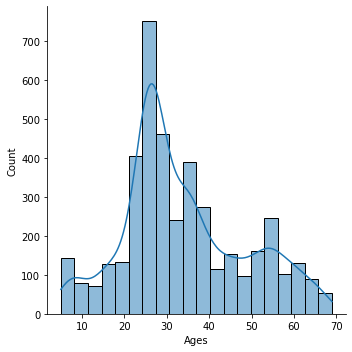

In [10]:
sns.displot(df['Ages'],kde=True, bins=20)

# Prepare datasets

In [11]:
X = []
Y = []  # age
Z = []  # gender

def make_X(a):
    b = a.resize((size,size), Image.ANTIALIAS)
    ar = np.asarray(b)
    X.append(ar) 
        
df['Images'].map(make_X)          
X = np.array(X)
Y = np.array(df['Ages'])
Z = np.array(df['Genders'])

print(X.shape)
print(Y.shape)
print(Z.shape)

(4221, 200, 200, 3)
(4221,)
(4221,)


##  Train and Validation data

In [12]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=0)

for train_index, test_index in sss.split(X, Y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    z_train, z_test = Z[train_index], Z[test_index]

print(X_train.shape)
print(y_train.shape)
print(z_train.shape)


(2828, 200, 200, 3)
(2828,)
(2828,)


# Define model with Multiple outputs (1: predict age, 2: classify gender)

In [14]:
inputs = Input(shape=(size, size, 3), name='input')

x = Conv2D(32, (3,3), activation='relu', name='C32')(inputs)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', name='C64')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu', name='C128')(x)
x = MaxPooling2D(2,2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu', name='D64')(x)

# x = Dense(64, activation='relu', name='D16')(x)
x = Dropout(0.2)(x)

age_out    = Dense(1,activation='relu', name='age')(x)
gender_out = Dense(1, activation='sigmoid', name='gender')(x)

model = Model(inputs=inputs, outputs=[age_out, gender_out])

model.compile(loss={'age': 'mean_absolute_error','gender': 'binary_crossentropy'},
              optimizer=optimizers.Adam(lr=0.0001),
              metrics={'age': 'mean_absolute_error', 'gender': 'accuracy'})

history = model.fit(X_train, {'age': y_train, 'gender': z_train}, epochs=n_epochs, batch_size= n_batch_size,validation_data=(X_test,{'age': y_test, 'gender': z_test}))

Epoch 1/30
84/84 [==============================] - 8s 39ms/step - loss: 29.5754 - age_loss: 17.4938 - gender_loss: 12.0816 - age_mean_absolute_error: 17.4938 - gender_accuracy: 0.5657 - val_loss: 11.0729 - val_age_loss: 10.6231 - val_gender_loss: 0.4498 - val_age_mean_absolute_error: 10.6231 - val_gender_accuracy: 0.8033
Epoch 2/30
84/84 [==============================] - 2s 29ms/step - loss: 12.3271 - age_loss: 11.5432 - gender_loss: 0.7839 - age_mean_absolute_error: 11.5432 - gender_accuracy: 0.6988 - val_loss: 10.6912 - val_age_loss: 10.3012 - val_gender_loss: 0.3900 - val_age_mean_absolute_error: 10.3012 - val_gender_accuracy: 0.8421
Epoch 3/30
84/84 [==============================] - 2s 30ms/step - loss: 10.8758 - age_loss: 10.3030 - gender_loss: 0.5728 - age_mean_absolute_error: 10.3030 - gender_accuracy: 0.7678 - val_loss: 9.8674 - val_age_loss: 9.4692 - val_gender_loss: 0.3982 - val_age_mean_absolute_error: 9.4692 - val_gender_accuracy: 0.8342
Epoch 4/30
84/84 [===============

# Evaluation results

In [18]:
_, age_loss,gender_loss, age_mean_absolute_error,gender_accuracy = model.evaluate(X_train,[y_train,z_train])
print("\nTrain Status:")
print("Age_MAE = ",age_mean_absolute_error)
print("Gender_accuracy = ",gender_accuracy,"\n")

_, age_loss,gender_loss, age_mean_absolute_error,gender_accuracy = model.evaluate(X_test,[y_test,z_test])
print("\nValidation Status:")
print("Age_MAE = ",age_mean_absolute_error)
print("Gender_accuracy = ",gender_accuracy)

89/89 [==============================] - 1s 9ms/step - loss: 3.7728 - age_loss: 3.6638 - gender_loss: 0.1089 - age_mean_absolute_error: 3.6638 - gender_accuracy: 0.9611

Train Status:
Age_MAE =  3.6638169288635254
Gender_accuracy =  0.9611032605171204 

44/44 [==============================] - 0s 9ms/step - loss: 8.7618 - age_loss: 8.4966 - gender_loss: 0.2652 - age_mean_absolute_error: 8.4966 - gender_accuracy: 0.8952

Validation Status:
Age_MAE =  8.496556282043457
Gender_accuracy =  0.8951902389526367
